In [2]:
import numpy as np
import cv2
import IPython
from PIL import Image
import os
import matplotlib.pyplot as plt


root2 = np.sqrt(2)


def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)


def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]

    if (width > 192):
        image_gray = image_gray.resize((192, 192))
        pixels = list(image_gray.getdata())

    else:
        pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((192, 192))


def concatenate_matrices(m1, m2, m3, m4):
    return np.concatenate((np.concatenate((m1, m2), axis=1),
                           np.concatenate((m3, m4), axis=1)), axis=0)


def p_new(matrix):
    max, min = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix


def split_matrix(matrix):  # divide the matrix into 4 quadrants
    leftSide, rightSide = np.split(matrix, 2, axis=1)
    appr, vD = np.split(leftSide, 2, axis=0)
    hD, dD = np.split(rightSide, 2, axis=0)

    return appr, hD, vD, dD


def direct_wavelet2D_H(matrix):  # does the direct wavelet transform horizontally
    Nf, N2, output = matrix.shape[0], matrix.shape[0]//2, np.zeros_like(
        matrix, dtype=float)
    for c in range(0, Nf, 2):
        output[:, c//2] = (matrix[:, c] + matrix[:, c+1]) / root2
        output[:, c//2 + N2] = (matrix[:, c] - matrix[:, c+1]) / root2
    return output


def direct_wavelet2D_V(matrix):  # does the direct wavelet transform vertically
    Nf, N2, output = matrix.shape[0], matrix.shape[0]//2, np.copy(matrix)
    for f in range(0, Nf, 2):
        output[f // 2, :] = (matrix[f, :] + matrix[f + 1, :]) / root2
        output[f//2 + N2, :] = (matrix[f, :] - matrix[f + 1, :]) / root2
    return output


def inverse_wavelet2D_H(matrix):
    Nf, N2 = matrix.shape[1], matrix.shape[1]//2
    output = np.zeros_like(matrix, dtype=float)
    for c in range(N2):
        output[:, c*2] = (matrix[:, c] + matrix[:, c+N2]) / root2
        output[:, c*2+1] = (matrix[:, c] - matrix[:, c+N2]) / root2
    return output


def inverse_wavelet2D_V(matrix):
    N2, Nf = matrix.shape[0]//2, matrix.shape[0]
    output = np.copy(matrix)
    for f in range(N2):
        output[f*2, :] = (matrix[f, :] + matrix[f+N2, :]) / root2
        output[f*2+1, :] = (matrix[f, :] - matrix[f+N2, :]) / root2
    return output


In [3]:
datarute = r'C:\Users\ZIGH\Documents\ENSEA\INTERNSHIP\CNN\UTKFace-crop_Renamed'

image_files = os.listdir(datarute)
random_index = np.random.randint(0, len(image_files) - 1)
random_image_filename = image_files[random_index]
random_image_path = os.path.join(datarute, random_image_filename)
print(random_image_path)

C:\Users\ZIGH\Documents\ENSEA\INTERNSHIP\CNN\UTKFace-crop_Renamed\30_0_20170117190440778.jpg


In [4]:
# photo = 'images/foto_dataset1.jpg'
image_array = jpg_to_pgm(random_image_path)

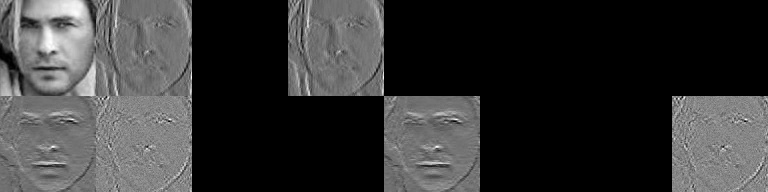

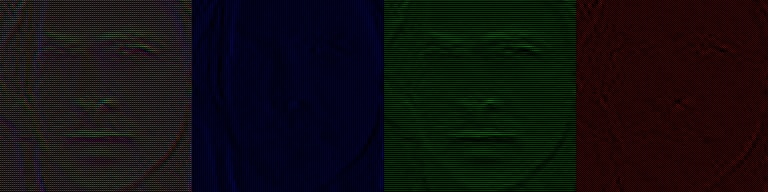

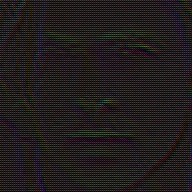

In [5]:
# DIRECT WAVELET TRANSFORM 
result_data = direct_wavelet2D_V(direct_wavelet2D_H(image_array))
cA, cH, cV, cD = split_matrix(result_data)

reconstructed = inverse_wavelet2D_H(inverse_wavelet2D_V(result_data))

(p_new(cA), p_new(cH), p_new(cV), p_new(cD))
#######################  Details  ############################
#           cH1 = np.zeros((96, 96))
cA1, cH1, cV1, cD1 = split_matrix(result_data)
cA1 = np.zeros((96, 96))
cV1 = np.zeros((96, 96))
cD1 = np.zeros((96, 96))

#           cV2 = np.zeros((96, 96))
cA2, cH2, cV2, cD2 = split_matrix(result_data)
cA2 = np.zeros((96, 96))
cH2 = np.zeros((96, 96))
cD2 = np.zeros((96, 96))

#           cD3 = np.zeros((96, 96))
cA3, cH3, cV3, cD3 = split_matrix(result_data)
cA3 = np.zeros((96, 96))
cH3 = np.zeros((96, 96))
cV3 = np.zeros((96, 96))
################################################################


# Concatenate all the matrix
horizontal1 = concatenate_matrices(cA1, cH1, cV1, cD1)
horizontal2 = concatenate_matrices(cA2, cH2, cV2, cD2)
horizontal3 = concatenate_matrices(cA3, cH3, cV3, cD3)


reconstructed1 = inverse_wavelet2D_H(inverse_wavelet2D_V(horizontal1))
reconstructed2 = inverse_wavelet2D_H(inverse_wavelet2D_V(horizontal2))
reconstructed3 = inverse_wavelet2D_H(inverse_wavelet2D_V(horizontal3))


dH_redChannel = np.stack((reconstructed1,)*3, axis=-1)
dH_redChannel[:,:,1] = 0
dH_redChannel[:,:,2] = 0

dV_greenChannel = np.stack((reconstructed2,)*3, axis=-1)
dV_greenChannel[:,:,0] = 0
dV_greenChannel[:,:,2] = 0

dD_blueChannel = np.stack((reconstructed3,)*3, axis=-1)
dD_blueChannel[:,:,0] = 0
dD_blueChannel[:,:,1] = 0


# show reconstructed image
imshow(np.concatenate((result_data, horizontal1, horizontal2, horizontal3), axis=1))

# Add all the channels and show the final image
final_image = dH_redChannel + dV_greenChannel + dD_blueChannel

# Show concatenated dH_redChannel, dV_greenChannel, dD_blueChannel
imshow(np.concatenate((final_image, dH_redChannel, dV_greenChannel, dD_blueChannel), axis=1))

imshow(final_image,5164)
# imshow(image_array,256)